In [1]:
# Librerías
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,r2_score)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
columns = ["sex","length", "diameter", "height", "whole_weight", "meat_weight", "viscera_weight","shell_weight","rings"]
df = pd.read_csv("../Data/abalone.data", names=columns)
df_X = df.drop(columns=['rings'])
df.head()

,sex,length,diameter,height,whole_weight,meat_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   meat_weight     4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


A pesar de que parece no haber valores faltantes, hay características en las cuales el 0 indica un dato faltante. Tal es el caso de pesos y longitudes. 
En la siguiente viñeta se realiza un conteo de observaciones con valor igual a 0.

In [145]:
conteo_por_columna = (df == 0).sum()
conteo_por_columna

sex               0
length            0
diameter          0
height            2
whole_weight      0
meat_weight       0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64

# Identificación de valores atipicos. 

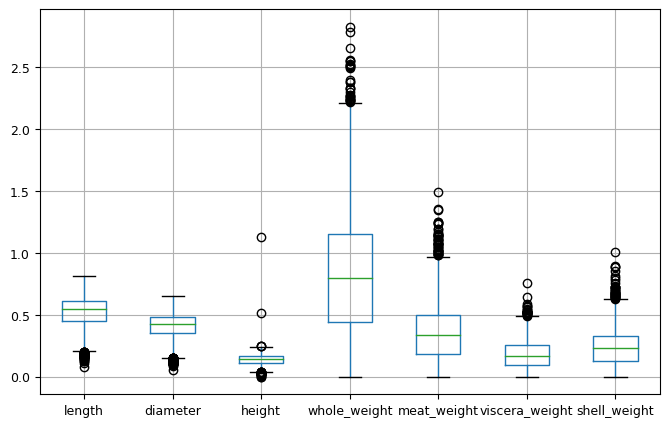

In [146]:
# PANDAS BOXPLOT documentación: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
# Primero obtenemos el boxplot utilizando el return_type both, para poder extraer datos 
axes, boxplot_dict = pd.DataFrame.boxplot(df_X, return_type='both', fontsize=9, figsize=(8,5))
plt.show()

En distintas variables hay outliers, hay que considerar que en la variable sexo también se incluye la clase 'infante'. En el caso de la altura hay observaciones que son de especial interes por estar muy lejana,  además de los casos ya vistos en que eran ceros. Esto podría indicar error de medición.
Para mejorar un poco el conjunto de datos, se eliminan las outliers de height y whole_weight.


In [147]:
# Para obtener las outliers, utilizaremos la key 'fliers' 
# y como cada key tiene dentro objetos del tipo 'matplotlib.lines.Line2D', utilizamos la función get_ydata
outliers = [flier.get_ydata() for flier in boxplot_dict["fliers"]]
outliers_height = outliers[2]
outliers_height

array([0.01, 0.03, 0.03, 0.035, 0.03, 0.02, 0.035, 0.025, 0.025, 0.015,
       0.0, 0.035, 0.025, 0.035, 0.015, 0.03, 0.03, 0.025, 0.03, 0.025,
       0.035, 0.035, 0.02, 0.0, 0.515, 0.25, 0.25, 1.13, 0.25],
      dtype=object)

In [148]:
outliers_whole_weight = outliers[3]
outliers_whole_weight

array([2.55, 2.499, 2.8255, 2.555, 2.302, 2.273, 2.236, 2.505, 2.657,
       2.25, 2.5085, 2.255, 2.2205, 2.5155, 2.7795, 2.226, 2.526, 2.381,
       2.398, 2.3305, 2.2355, 2.3235, 2.2305, 2.2635, 2.2695, 2.4925,
       2.333, 2.548, 2.381, 2.2385], dtype=object)

Como es posible observar, se reduce bastante los valores atípicos. Al tratarse de mediciones tan pequeñas, se decide no continuar con la eliminación de atípicos y revisar otra vez cuantas observaciones quedan. 

In [149]:
# Eliminación de outliers
df = df[~df.height.isin(outliers_height)]
df = df[~df.whole_weight.isin(outliers_whole_weight)]
# Resetear indices para evitar problemas en el PCA
df = df.reset_index(drop=True)
df

,sex,length,diameter,height,whole_weight,meat_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4115,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4116,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4117,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4118,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


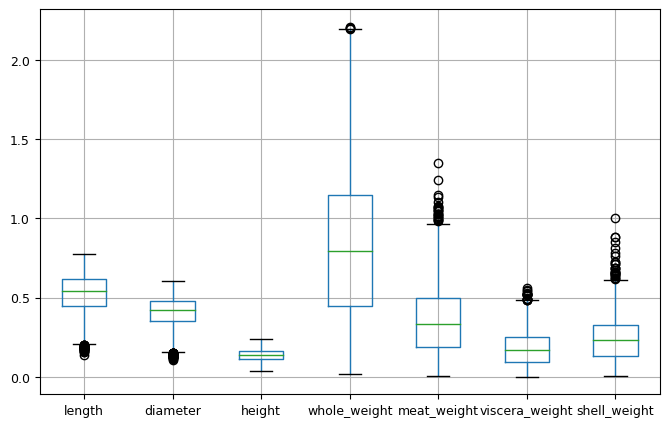

In [150]:
df_X = df.drop(columns=['rings'])
boxplot = df_X.boxplot(fontsize=9, figsize=(8,5))
plt.show()

In [151]:
df.describe()

,length,diameter,height,whole_weight,meat_weight,viscera_weight,shell_weight,rings
count,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000
mean,0.524242,0.408028,0.139297,0.821193,0.355680,0.179205,0.237133,9.946602
std,0.116367,0.096246,0.037154,0.470582,0.212181,0.106062,0.134931,3.197028
min,0.135000,0.105000,0.040000,0.015500,0.005000,0.000500,0.005000,3.000000
25%,0.450000,0.350000,0.115000,0.444375,0.187000,0.093875,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.797500,0.335500,0.170000,0.232500,9.000000
75%,0.615000,0.480000,0.165000,1.145000,0.498500,0.250500,0.325000,11.000000
max,0.775000,0.605000,0.240000,2.210000,1.351000,0.564000,1.005000,29.000000


# Imprimimos la distribución de las variables

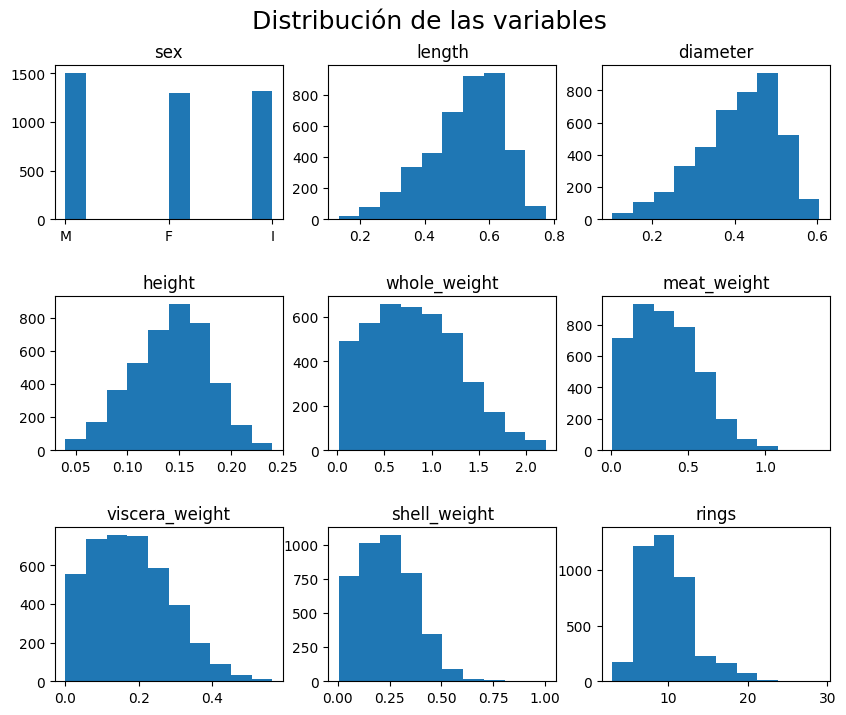

In [152]:
# Imprimir la distribución de las variables
# Se define el grid de la subplot
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Distribución de las variables", fontsize=18, y=0.95)

for col_name, ax in zip(df.columns, axs.ravel()):
    ax.hist(df[col_name].dropna(), bins=10)
    ax.set_title(col_name)
plt.show()

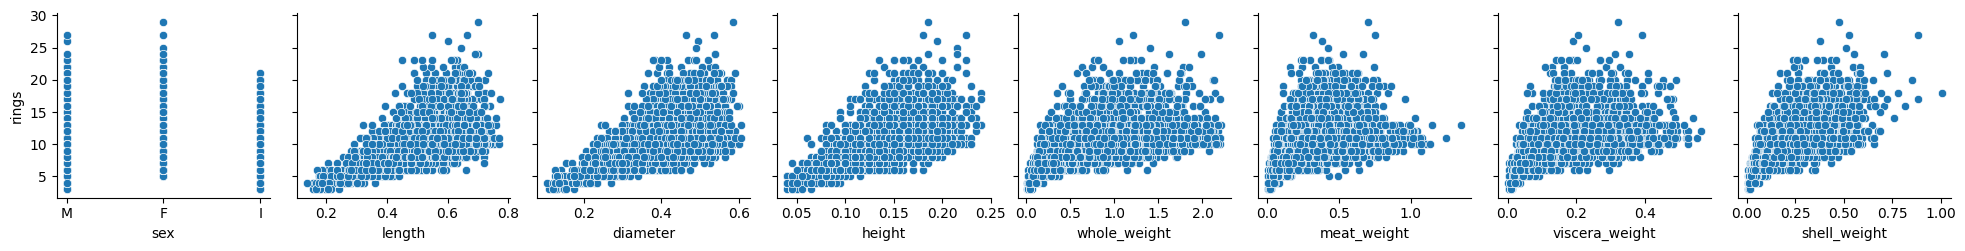

In [153]:
# Para darnos una idea de como se comportan los datos con respecto a la salida, se puede mostrar este grafico.
x_column_names = ["sex","length", "diameter", "height", "whole_weight", "meat_weight", "viscera_weight","shell_weight"]
y_column_name = "rings"
fig = sns.pairplot(df,x_vars=x_column_names,y_vars=y_column_name)
plt.show()

# División train-test

In [154]:
# Antes de continuar, se convierte la variable sexo a dummy 
# Aplicando la codificación one-hot
df_encoded = pd.get_dummies(df, columns=['sex'])

# Mostrar el nuevo DataFrame con las columnas one-hot
df_encoded

,length,diameter,height,whole_weight,meat_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4115,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4116,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4117,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4118,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


In [155]:
# Definimos una función para graficar resultados de las regresiones lineales
def draw_lm_results(y_test_p, x_test_p, model):
    ref_p = np.linspace(min(y_test_p),max(y_test_p))
    y_predict_p = model.predict(x_test_p)
    fig = plt.figure(figsize=(10,8))
    plt.scatter(y_test_p,y_predict_p)
    plt.plot(ref_p,ref_p,'k--')
    plt.axis('square')
    plt.xlabel('y real'),plt.ylabel('y predict')
    mse_p = mean_squared_error(y_test_p,y_predict_p, squared=False)
    r2_p = r2_score(y_test_p,y_predict_p)
    plt.title(f"Linear regression (original), RMSE={mse_p:.10f}, R^2={r2_p:.10f}")
    plt.grid()
    plt.show()

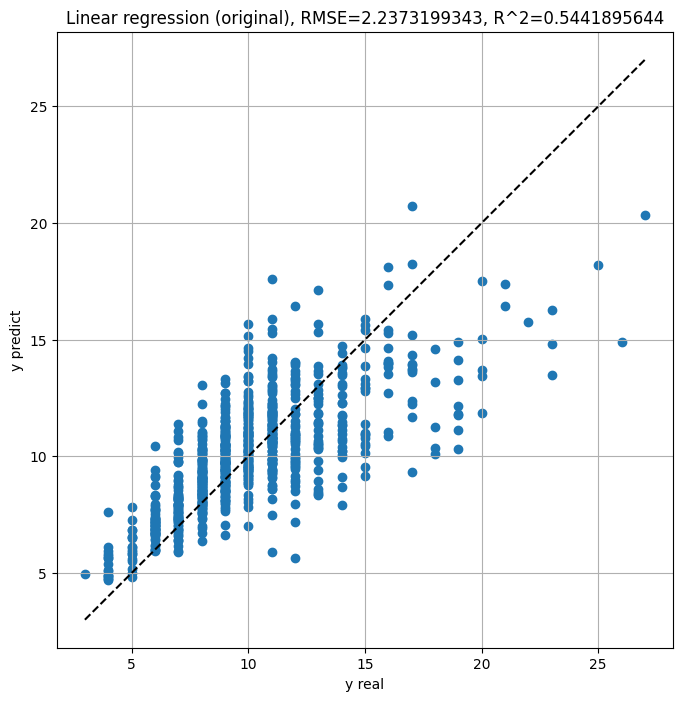

In [156]:
# Dividir datos en entrenamiento y testing
x_names = ["sex_F","sex_I","sex_M","length", "diameter", "height", "whole_weight", "meat_weight", "viscera_weight","shell_weight"]
x_train, x_test, y_train, y_test = train_test_split(df_encoded[x_names], df_encoded.rings,
                                                    test_size=0.2, random_state=42)
# Modelo lineal simple
linreg = LinearRegression()
linreg.fit(x_train, y_train)
draw_lm_results(y_test, x_test, linreg)

In [157]:
# Selección de características por el criterio de la varianza
# regresamos al dataset encoded y revisamos sus varianzas
varianza_ftrs = df_encoded[x_names].var()
varianza_ftrs

sex_F             0.215395
sex_I             0.217793
sex_M             0.232040
length            0.013541
diameter          0.009263
height            0.001380
whole_weight      0.221447
meat_weight       0.045021
viscera_weight    0.011249
shell_weight      0.018206
dtype: float64

In [158]:
# El umbral definido en este caso es eliminar las variables con 1% de la varianza total:
umbral = 0.01 * varianza_ftrs.sum()
umbral

0.009853362461518904

In [159]:
# Características cuya varianza es menor/igual que el umbral se eliminan
ftr_drop = varianza_ftrs[varianza_ftrs <= umbral].index.tolist()
ftr_drop

['diameter', 'height']

In [160]:
# Características cuya varianza es mayor/igual que el umbral se mantienen
ftr_keep = varianza_ftrs[varianza_ftrs >= umbral].index.tolist()
ftr_keep

['sex_F',
 'sex_I',
 'sex_M',
 'length',
 'whole_weight',
 'meat_weight',
 'viscera_weight',
 'shell_weight']

In [161]:
# Nuevo conjunto de dato con los datos seleccionados eliminando las de menor varianza
data_sel = df_encoded[ftr_keep].copy()
data_sel["rings"] = df_encoded["rings"]
data_sel.head()

,sex_F,sex_I,sex_M,length,whole_weight,meat_weight,viscera_weight,shell_weight,rings
0,0,0,1,0.455,0.5140,0.2245,0.1010,0.150,15
1,0,0,1,0.350,0.2255,0.0995,0.0485,0.070,7
2,1,0,0,0.530,0.6770,0.2565,0.1415,0.210,9
3,0,0,1,0.440,0.5160,0.2155,0.1140,0.155,10
4,0,1,0,0.330,0.2050,0.0895,0.0395,0.055,7


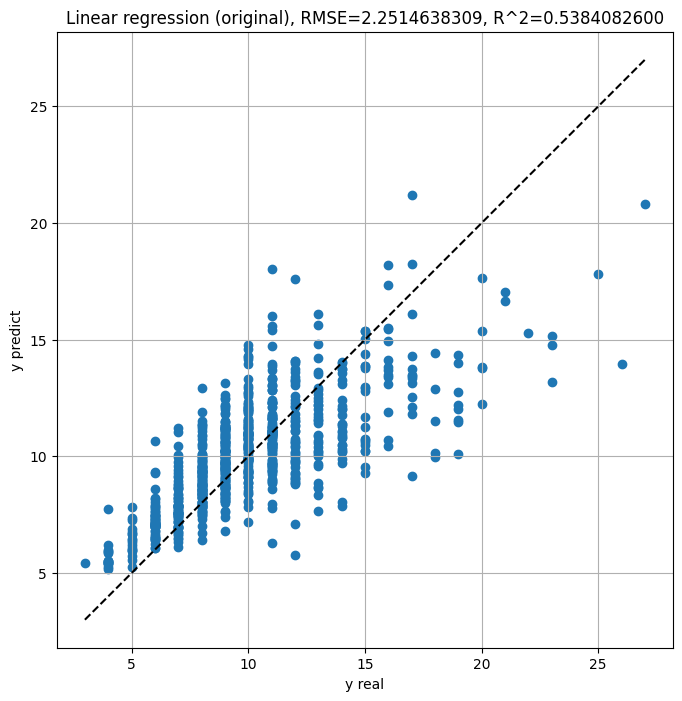

In [162]:
# Regresión lineal con dataset disminuido
x_train_sel, x_test_sel, y_train_sel, y_test_sel = train_test_split(data_sel[ftr_keep], data_sel.rings,
                                                    test_size=0.2, random_state=42)
                                                    # Modelo lineal simple
linreg_sel = LinearRegression()
linreg_sel.fit(x_train_sel, y_train_sel)
draw_lm_results(y_test_sel, x_test_sel, linreg_sel)


In [163]:
x_names

['sex_F',
 'sex_I',
 'sex_M',
 'length',
 'diameter',
 'height',
 'whole_weight',
 'meat_weight',
 'viscera_weight',
 'shell_weight']

In [164]:
# PCA
pca = PCA()
# Data frame original, pero codificado.
pca.fit(df_encoded[x_names])
data_pca = pca.transform(df_encoded[x_names])
data_pca = pd.DataFrame(data_pca)
data_pca['rings'] = df_encoded['rings'].copy()
data_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4120 non-null   float64
 1   1       4120 non-null   float64
 2   2       4120 non-null   float64
 3   3       4120 non-null   float64
 4   4       4120 non-null   float64
 5   5       4120 non-null   float64
 6   6       4120 non-null   float64
 7   7       4120 non-null   float64
 8   8       4120 non-null   float64
 9   9       4120 non-null   float64
 10  rings   4120 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 354.2 KB


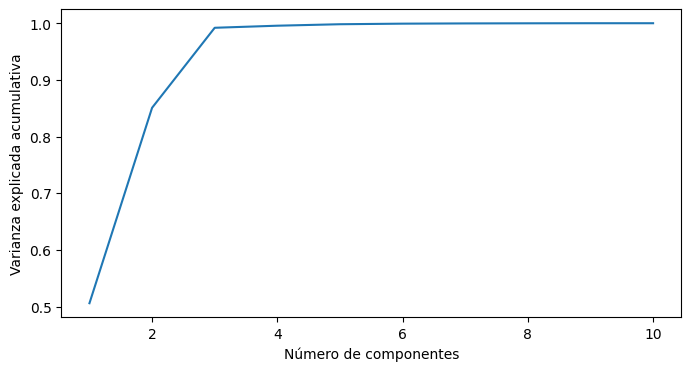

In [166]:
# Antes que nada, vamos a revisar la varianza acumulada para decidir cuantos componentes dejar 
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
fig = plt.figure(figsize=(8,4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulativa')
plt.show()

En este  gráfico se puede observar que más del 95% de la varianza está en 3 componentes. Ese es el criterio para dejar solamente los componentes 1,2 y 3. 

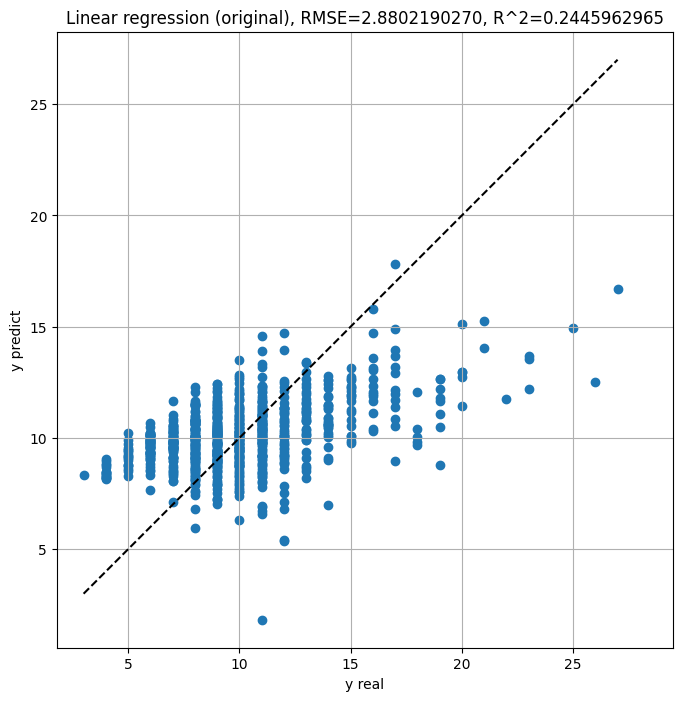

In [168]:
X_train, X_test, y_train, y_test = train_test_split(data_pca[[1,2,3]], data_pca.rings,
                                                    test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(np.array(X_train[[1,2,3]]), y_train)

draw_lm_results(y_test, X_test, linreg)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded[x_names], df_encoded.rings,
                                                    test_size=0.2, random_state=42)
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

data_pls = pls.transform(df_encoded[x_names])
data_pls = pd.DataFrame(data_pls)
data_pls['rings'] = df_encoded['rings'].copy()
data_pls.head()

,0,1,2,3,4,rings
0,-1.529772,-0.057397,0.118032,1.700543,-0.368237,15
1,-3.065502,-0.343146,0.208830,2.028758,-0.244820,7
2,-0.046006,-0.817018,0.699305,-0.327598,0.098367,9
3,-1.210760,-0.372734,-0.330558,1.581729,0.033487,10
4,-4.192140,0.335685,0.105647,-0.458567,-0.246089,7


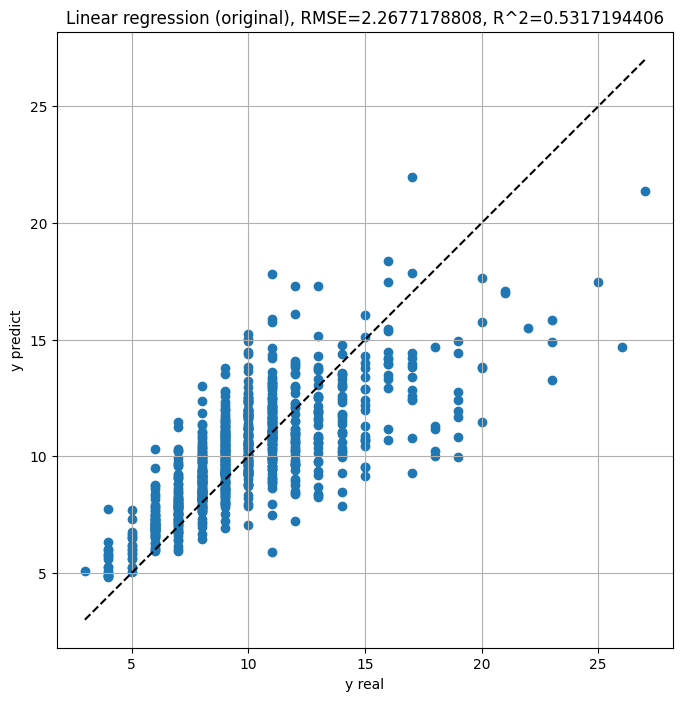

In [186]:
draw_lm_results(y_test, X_test, pls)